In [1]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!mkdir data
!tar -xvzf images.tar.gz -C data
!tar -xvzf annotations.tar.gz -C data


Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [3]:
label_file = "data/annotations/trainval.txt"
image_folder = "data/images"

df = pd.read_csv(label_file, sep=" ", names=["filename", "class_id", "species", "breed_id"])
df["filename"] = df["filename"] + ".jpg"
df["class_id"] = df["class_id"] - 1

num_classes = df["class_id"].nunique()
print("Total pet breeds:", num_classes)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["class_id"])


Total pet breeds: 37


In [4]:
IMG_SIZE = (128, 128)

def load_data(dataframe):
    X, y = [], []
    for i, row in dataframe.iterrows():
        path = os.path.join(image_folder, row["filename"])
        if os.path.exists(path):
            img = load_img(path, target_size=IMG_SIZE)
            img = img_to_array(img) / 255.0  # Normalize
            X.append(img)
            y.append(row["class_id"])
    return np.array(X), np.array(y)

X_train, y_train = load_data(train_df)
X_val, y_val = load_data(val_df)

print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))


Train samples: 2944
Validation samples: 736


In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,309,413 (12.62 MB)

 Trainable params: 3,309,413 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.0235 - loss: 3.6590 - val_accuracy: 0.0503 - val_loss: 3.6058
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 136s 974ms/step - accuracy: 0.0422 - loss: 3.5827 - val_accuracy: 0.0625 - val_loss: 3.5135
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 950ms/step - accuracy: 0.0597 - loss: 3.4754 - val_accuracy: 0.0639 - val_loss: 3.4425
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.1118 - loss: 3.3474 - val_accuracy: 0.0720 - val_loss: 3.4161
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 992ms/step - accuracy: 0.1496 - loss: 3.1337 - val_accuracy: 0.0938 - val_loss: 3.3888
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 942ms/step - accuracy: 0.2456 - loss: 2.7501 - val_accuracy: 0.1073 - val_loss: 3.4861
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.3352 - loss: 2.3775 - val_accuracy: 0.0938 - val_loss: 3.6112
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.4592 - loss: 1.9436 - val_accuracy: 

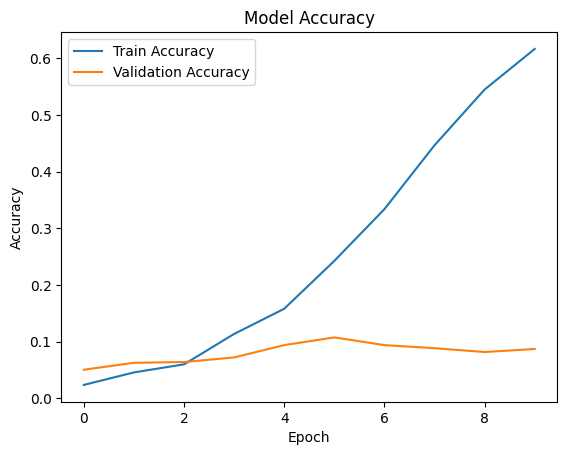

In [7]:
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [8]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.2f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.0838 - loss: 4.5990
Validation Accuracy: 0.09


In [73]:
def predict_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    return predicted_class



In [83]:
df['breed_name'] = df['filename'].str.extract(r'^(.+)_\d+\.jpg')

id_to_breed = df[['class_id', 'breed_name']].drop_duplicates().set_index('class_id')['breed_name'].to_dict()

def predict_image_with_breed(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    predicted_class = int(np.argmax(prediction))
    breed_name = id_to_breed.get(predicted_class, "Unknown")
    return predicted_class, breed_name




In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(12, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cat_breeds = [
    "Abyssinian", "Bengal", "Birman", "Bombay", "British_Shorthair",
    "Egyptian_Mau", "Maine_Coon", "Persian", "Ragdoll",
    "Russian_Blue", "Siamese", "Sphynx"
]
breed_to_id = {b: i for i, b in enumerate(cat_breeds)}
df['breed_name_cleaned'] = df['breed_name'].str.replace("_", "", regex=False)
cat_breeds_cleaned = [b.replace("_", "") for b in cat_breeds]
breed_name_lookup = dict(zip(cat_breeds_cleaned, cat_breeds))

df = df[df['breed_name_cleaned'].isin(cat_breeds_cleaned)].reset_index(drop=True)
df['breed_name'] = df['breed_name_cleaned'].map(breed_name_lookup)
df['class_id'] = df['breed_name'].map(breed_to_id)
id_to_breed = {i: b for i, b in enumerate(cat_breeds)}


In [90]:
predict_image_with_breed("data/images/toby.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


(8, 'Ragdoll')

In [91]:
model.save("breed_classifier.h5")

In [92]:
from google.colab import files
files.download("breed_classifier.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>